In [29]:
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
import gensim
import multiprocessing

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/archit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
article_df = pd.concat(map(pd.read_csv, ['archive/articles1.csv', 'archive/articles2.csv', 'archive/articles3.csv']))
print(article_df.head())

   Unnamed: 0     id                                              title  \
0           0  17283  House Republicans Fret About Winning Their Hea...   
1           1  17284  Rift Between Officers and Residents as Killing...   
2           2  17285  Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...   
3           3  17286  Among Deaths in 2016, a Heavy Toll in Pop Musi...   
4           4  17287  Kim Jong-un Says North Korea Is Preparing to T...   

      publication                         author        date    year  month  \
0  New York Times                     Carl Hulse  2016-12-31  2016.0   12.0   
1  New York Times  Benjamin Mueller and Al Baker  2017-06-19  2017.0    6.0   
2  New York Times                   Margalit Fox  2017-01-06  2017.0    1.0   
3  New York Times               William McDonald  2017-04-10  2017.0    4.0   
4  New York Times                  Choe Sang-Hun  2017-01-02  2017.0    1.0   

   url                                            content  
0  NaN  WASHIN

In [31]:
article_df

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...,...
42566,146028,218078,An eavesdropping Uber driver saved his 16-year...,Washington Post,Avi Selk,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Uber driver Keith Avila picked up a p...
42567,146029,218079,Plane carrying six people returning from a Cav...,Washington Post,Sarah Larimer,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,Crews on Friday continued to search L...
42568,146030,218080,After helping a fraction of homeowners expecte...,Washington Post,Renae Merle,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,When the Obama administration announced a...
42569,146031,218081,"Yes, this is real: Michigan just banned bannin...",Washington Post,Chelsea Harvey,2016-12-30,2016.0,12.0,https://web.archive.org/web/20161231004909/htt...,This story has been updated. A new law in...


In [32]:
article_df = article_df[['publication', 'content']]
article_df

,publication,content
0,New York Times,WASHINGTON — Congressional Republicans have...
1,New York Times,"After the bullet shells get counted, the blood..."
2,New York Times,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,New York Times,"Death may be the great equalizer, but it isn’t..."
4,New York Times,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...
42566,Washington Post,Uber driver Keith Avila picked up a p...
42567,Washington Post,Crews on Friday continued to search L...
42568,Washington Post,When the Obama administration announced a...
42569,Washington Post,This story has been updated. A new law in...


In [33]:
def clean(text):
    text = re.sub(r'\|\|\|', r' ', text)
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text

def remove_stopwords(text):
    engl_stops = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in engl_stops])

article_df['content'] = article_df['content'].apply(clean)
article_df['content'] = article_df['content'].apply(remove_stopwords)

mappings = {
    'Atlantic': 0,
    'Breitbart': 1,
    'Business Insider': 0,
    'CNN': 0,
    'Fox News': 1,
    'Guardian': 0,
    'National Review': 1,
    'New York Post': 1,
    'New York Times': 0,
    'Vox': 0,
    'Washington Post': 0
}
article_df = article_df[article_df['publication'].isin(mappings)]
article_df["label"] = article_df['publication'].map(mappings.get)
article_df = article_df.iloc[np.random.permutation(len(article_df))]
article_df = article_df[['content', 'label']]
article_df

/var/folders/_s/t0dxy3t91bn2pn1_261pdm680000gn/T/ipykernel_24465/1235089655.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_df['content'] = article_df['content'].apply(clean)
/var/folders/_s/t0dxy3t91bn2pn1_261pdm680000gn/T/ipykernel_24465/1235089655.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_df['content'] = article_df['content'].apply(remove_stopwords)
/var/folders/_s/t0dxy3t91bn2pn1_261pdm680000gn/T/ipykernel_24465/1235089655.py:32: SettingWithCopyWarning: 
A value is trying

,content,label
32387,"sacramento, california (cnn) it’s recent frida...",0
5024,follow latest updates monday’s vote electoral ...,0
9059,"group attorneys, scholars, advocates put names...",1
27675,"president donald trump, campaign trail, firmly...",0
6226,opportunity defeating enemy provided enemy him...,0
...,...,...
35661,"(cnn)”i human, love heart beats always win, un...",0
39326,"device old shakespeare, dramatically durable s...",0
16891,"greenville, south carolina — capacity crowd hu...",1
49282,i’m delighted let know today reached important...,0


In [34]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

train, test = train_test_split(article_df, test_size=0.2)
count = 0
total = len(article_df)

def tokenize(text):
    global count
    global total
    count += 1
    print(f"{count}/{total}", end="\r")
    return list(filter(lambda word : len(word) > 3, word_tokenize(text)))

train_tagged = train.apply(lambda x: TaggedDocument(words=tokenize(x['content']), tags=  [x.label]), axis=1)
test_tagged = test.apply(lambda x: TaggedDocument(words=tokenize(x['content']), tags=[x.label]), axis=1)
test_tagged.values

array([TaggedDocument(words=['berlin', 'small', 'swiss', 'town', 'rupperswil', 'shock', 'learning', 'local', 'youth', 'soccer', 'coach', 'suspected', 'behind', 'brutal', 'killings', 'four', 'people', 'last', 'december', 'swiss', 'citizen', 'named', 'local', 'media', 'thomas', 'suspected', 'killing', 'mother', 'teenage', 'sons', 'another', 'woman', 'town', 'miles', 'west', 'zurich', 'prosecutors', 'said', 'suspect', 'made', 'comprehensive', 'confession', 'arrest', 'thursday', 'roland', 'wenger', 'spokesman', 'sarmenstorf', 'soccer', 'club', 'suspect', 'coach', 'said', 'members', 'horrified', 'news', 'nobody', 'club', 'would', 'thought', 'thomas', 'would', 'capable', 'this', 'always', 'decent', 'told', 'daily', 'interview', 'published', 'saturday', 'rupperswil', 'mayor', 'rudolf', 'hediger', 'told', 'daily', 'aargauer', 'zeitung', 'relief', 'arrest', 'also', 'certain', 'amount', 'shame', 'dismay', 'really', 'member', 'village', 'community', 'prosecutor', 'barbara', 'loppacher', 'said', '

In [35]:
from sklearn import utils
from gensim.models.callbacks import CallbackAny2Vec
import os

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print(f"Starting epoch {self.epoch}")
        
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print(f'Loss after epoch {self.epoch}: {loss}')


doc_2_vec_path = './models/Doc2Vec/article_bias_doc2vec.model'
vec_model = None
if not os.path.exists(doc_2_vec_path):
    cores = multiprocessing.cpu_count()
    vec_model = Doc2Vec(dm=0, vector_size=500, negative=5, hs=0, sample=0, min_count=2, workers=cores)
    print("Initialized model")
    vec_model.build_vocab(train_tagged.values)
    print("Built vocab")
    vec_model.train(utils.shuffle(train_tagged.values), total_examples=len(train_tagged.values), epochs=10, callbacks=[Callback()])
else:
    vec_model = Doc2Vec.load(doc_2_vec_path)

In [36]:
def generate_vectors(model, tag_docs):
    docs = tag_docs.values
    data, labels = [], []
    doc_len = len(docs)
    for i, doc in enumerate(docs):
        print(f"{i + 1}/{doc_len}", end="\r")
        labels.append(doc.tags[0])
        data.append(model.infer_vector(doc.words))
    return data, labels

x_train, y_train = generate_vectors(vec_model, train_tagged)
x_test, y_test = generate_vectors(vec_model, test_tagged)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=3)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
accuracy_score(predictions, y_test)
# about 82% accurate prediction

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s


building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.8223132969034609

In [38]:
from sklearn.svm import SVC

svc = SVC(verbose=True)
svc.fit(x_train, y_train)
accuracy_score(svc.predict(x_test), y_test)
# about 90% accurate prediction

[LibSVM]
systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

..............................*.........*
optimization finished, #iter = 39007
obj = -20325.713367, rho = -0.863930
nSV = 30839, nBSV = 20705
Total nSV = 30839


0.8981785063752277

In [39]:
import pickle

pickle.dump(rf, open('rf_bias.pickle', 'wb'))
pickle.dump(svc, open('svc_bias.pickle', 'wb'))
vec_model.save('article_bias_doc2vec.model')

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Accuracy, Precision, Recall

tf_x_train, tf_y_train = np.asarray(x_train), np.asarray(y_train)
tf_x_test, tf_y_test = np.asarray(x_train), np.asarray(y_train)

def one_hot_encode(y_arr):
    one_hot = []
    for label in y_arr:
        one_hot.append(np.asarray([0, 1]) if label == 0 else np.asarray([1, 0]))
    return np.asarray(one_hot)

tf_y_train = one_hot_encode(tf_y_train)
tf_y_test = one_hot_encode(tf_y_test)

tf_model = Sequential([
    Dense(512, activation='relu', input_shape=(500,)),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

tf_model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), 
              metrics=['acc', Precision(), Recall()])

tf_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               256512    
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 404,418
Trainable params: 404,418
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = tf_model.fit(
    tf_x_train, tf_y_train, batch_size=64, epochs = 50, verbose=1, validation_data=(tf_x_test, tf_y_test)
)

Epoch 1/50


2023-01-06 19:15:43.846892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1373/1373 [==============================] - ETA: 0s - loss: 0.6759 - acc: 0.5755 - precision_2: 0.5755 - recall_2: 0.5755

2023-01-06 19:16:01.850960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1373/1373 [==============================] - 30s 22ms/step - loss: 0.6759 - acc: 0.5755 - precision_2: 0.5755 - recall_2: 0.5755 - val_loss: 0.6538 - val_acc: 0.6373 - val_precision_2: 0.6373 - val_recall_2: 0.6373
Epoch 2/50
1373/1373 [==============================] - 30s 22ms/step - loss: 0.6319 - acc: 0.6830 - precision_2: 0.6830 - recall_2: 0.6830 - val_loss: 0.6087 - val_acc: 0.7294 - val_precision_2: 0.7294 - val_recall_2: 0.7294
Epoch 3/50
1373/1373 [==============================] - 30s 22ms/step - loss: 0.5830 - acc: 0.7580 - precision_2: 0.7580 - recall_2: 0.7580 - val_loss: 0.5552 - val_acc: 0.7817 - val_precision_2: 0.7817 - val_recall_2: 0.7817
Epoch 4/50
1373/1373 [==============================] - 30s 22ms/step - loss: 0.5256 - acc: 0.7987 - precision_2: 0.7987 - recall_2: 0.7987 - val_loss: 0.4962 - val_acc: 0.8110 - val_precision_2: 0.8110 - val_recall_2: 0.8110
Epoch 5/50
1373/1373 [==============================] - 30s 22ms/step - loss: 0.4704 - acc: 0.8193 - precis

1373/1373 [==============================] - 29s 21ms/step - loss: 0.2742 - acc: 0.8794 - precision_2: 0.8794 - recall_2: 0.8794 - val_loss: 0.2737 - val_acc: 0.8797 - val_precision_2: 0.8797 - val_recall_2: 0.8797
Epoch 38/50
1373/1373 [==============================] - 29s 21ms/step - loss: 0.2736 - acc: 0.8796 - precision_2: 0.8796 - recall_2: 0.8796 - val_loss: 0.2732 - val_acc: 0.8801 - val_precision_2: 0.8801 - val_recall_2: 0.8801
Epoch 39/50
1373/1373 [==============================] - 29s 21ms/step - loss: 0.2731 - acc: 0.8799 - precision_2: 0.8799 - recall_2: 0.8799 - val_loss: 0.2727 - val_acc: 0.8801 - val_precision_2: 0.8801 - val_recall_2: 0.8801
Epoch 40/50
1373/1373 [==============================] - 30s 22ms/step - loss: 0.2726 - acc: 0.8801 - precision_2: 0.8801 - recall_2: 0.8801 - val_loss: 0.2722 - val_acc: 0.8802 - val_precision_2: 0.8802 - val_recall_2: 0.8802
Epoch 41/50
1373/1373 [==============================] - 30s 21ms/step - loss: 0.2721 - acc: 0.8805 - pr

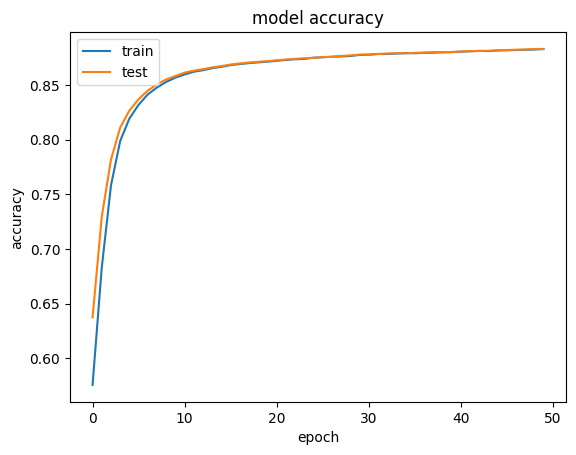

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

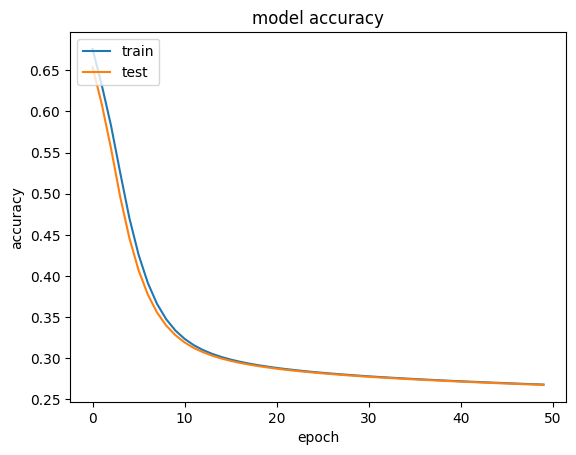

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
tf_model.save('article_bias_nn.h5')
# about 88% accurate